In [1]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")



2025-04-28 15:55:47.018149: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**15. Improving the encoder-section to incorporate MobileNet-V2 initial layers**

<img src = 'QUICKSAL.png' width = '700'/>


**Bottleneck Inverted Residual Block class**

In [15]:
@kr.utils.register_keras_serializable(package='BottleNeckInverseResidualBlock')
class BIR_Block(kr.layers.Layer):
    def __init__(self,input_channels,output_channels,expansion_factor,stride = 1,expansion_kernel_size = 1,depthwise_kernel_size = 3, **kwargs):
        super().__init__(**kwargs)

        self._block_name = kwargs.get('name','BIR_Block')
        self.stride = stride
        self.use_residual = (self.stride == 1 and input_channels == output_channels)
        expanded_channels = input_channels * expansion_factor

        # Expansion 
        self.expand_conv = tf.keras.layers.Conv2D(
            filters = expanded_channels,
            kernel_size = expansion_kernel_size,
            padding = 'same',
            use_bias = False,
            name = f'{self._block_name}_expand'
        )

        self.bn1 = tf.keras.layers.BatchNormalization(name = f'{self._block_name}_expand_BN')
        self.relu1 = tf.keras.layers.ReLU(name=f'{self._block_name}_expand_relu')

        # Depthwise convolution
        self.depthwise_conv = tf.keras.layers.DepthwiseConv2D(
            kernel_size = depthwise_kernel_size,
            strides = self.stride,
            padding = 'same',
            use_bias = False,
            name = f'{self._block_name}_depthwise'
        )
        self.bn2 = tf.keras.layers.BatchNormalization(name = f'{self._block_name}_depthwise_BN')
        self.relu2 = tf.keras.layers.ReLU(name=f'{self._block_name}_depthwise_relu')


        # Projection
        self.project_conv = tf.keras.layers.Conv2D(
            filters = output_channels,
            kernel_size = 1,
            padding = 'same',
            use_bias = False,
            name = f'{self._block_name}_project'
        )
        self.bn3 = tf.keras.layers.BatchNormalization(name = f'{self._block_name}_project_BN')


        # Addition layer
        self.add_layer = tf.keras.layers.Add(name = f'{self._block_name}_add')

        ### putting together all layers:
        

    def call(self,inputs,training = False):
        # expansion
        x = self.expand_conv(inputs)
        x = self.bn1(x,training = training)
        x = self.relu1(x)

        # depthwise convolution
        x = self.depthwise_conv(x)
        x = self.bn2(x,training = training)
        x = self.relu2(x)

        # projection
        x = self.project_conv(x)
        x = self.bn3(x,training = training)

        # residual connection
        if self.use_residual:
            return self.add_layer([inputs,x])
        else:
            return x

**Encoder-Block**

In [38]:
@kr.utils.register_keras_serializable(package='QUICKSAL_encoder')
class QUICKSAL_encoder(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

        self.mbnet = tf.keras.applications.MobileNetV2(
            include_top = False,
            alpha = 1.0,
            input_shape = (224,224,3),
            weights = 'imagenet'
        )

        self.block_args = {
            'block_2_1':{'input_channels':16,'output_channels': 24,'t':6,'stride':1},
            'block_2_2':{'input_channels':24,'output_channels': 24,'t':6,'stride':2},
            'block_3_1':{'input_channels':24,'output_channels': 32,'t':6,'stride':1},
            'block_3_2':{'input_channels':32,'output_channels': 32,'t':6,'stride':1},
            'block_3_3':{'input_channels':32,'output_channels': 32,'t':6,'stride':2},
            'block_4_1':{'input_channels':32,'output_channels': 64,'t':6,'stride':1},
            'block_4_2':{'input_channels':64,'output_channels': 64,'t':6,'stride':1},
            'block_4_3':{'input_channels':64,'output_channels': 64,'t':6,'stride':1},
            'block_4_4':{'input_channels':64,'output_channels': 64,'t':6,'stride':2},
            'block_5_1':{'input_channels':64,'output_channels': 96,'t':6,'stride':1},
            'block_5_2':{'input_channels':96,'output_channels': 96,'t':6,'stride':1},
            'block_5_3':{'input_channels':96,'output_channels': 96,'t':6,'stride':1},
            'block_6_1':{'input_channels':96,'output_channels': 160,'t':6,'stride':1},
            'block_6_2':{'input_channels':160,'output_channels': 160,'t':6,'stride':1},
            'block_6_3':{'input_channels':160,'output_channels': 160,'t':6,'stride':2},
            'block_7_1':{'input_channels':160,'output_channels': 320,'t':6,'stride':1},
        }


        # remaining layers have expansion kernal-size of 1x1
        self._layers = self.mbnet.layers[1:8]+[BIR_Block(input_channels = block_params['input_channels'],
                            output_channels = block_params['output_channels'],
                            expansion_factor = block_params['t'],
                            stride = block_params['stride'],
                            name = block_name) for block_name,block_params in self.block_args.items()]
        
        self.all_outputs = {}

    def call(self,inputs):
        x = self._layers[0](inputs)
        self.all_outputs[self._layers[0].name] = x
        for layer in self._layers[1:]:
            x = layer(x)
            self.all_outputs[layer.name] = x
        needed_outputs_from = ['Conv1','block_2_2','block_3_3','block_5_3','block_7_1']
        return [self.all_outputs[block_name] for block_name in needed_outputs_from]

In [39]:
def set_encoder_weights(enc,mbnet):
    # For block 2 to 7
    i=1
    # setting the weights
    for block in enc._layers[7:]:
        for layer in block._layers:
            # setting expand layer
            if layer.name[10:] == 'expand':
                layer.set_weights(mbnet.get_layer(f'block_{i}_expand').get_weights())
            elif layer.name[10:] == 'expand_BN':
                layer.set_weights(mbnet.get_layer(f'block_{i}_expand_BN').get_weights())
            elif layer.name[10:] == 'depthwise':
                layer.set_weights(mbnet.get_layer(f'block_{i}_depthwise').get_weights())
            elif layer.name[10:] == 'depthwise_BN':
                layer.set_weights(mbnet.get_layer(f'block_{i}_depthwise_BN').get_weights())
            elif layer.name[10:] == 'project':
                layer.set_weights(mbnet.get_layer(f'block_{i}_project').get_weights())
            elif layer.name[10:] == 'project_BN':
                layer.set_weights(mbnet.get_layer(f'block_{i}_project_BN').get_weights())
        i+=1

In [40]:
inputs = tf.keras.layers.Input(shape = (224,224,3))

enc = QUICKSAL_encoder(name="QUICKSAL_encoder")
_ = enc(tf.keras.layers.Input((224,224,3)))
set_encoder_weights(enc,enc.mbnet)

outputs = enc(inputs)
encoder_model = tf.keras.models.Model(inputs = inputs, outputs = outputs,name = 'encoder_model')
encoder_model.summary()

Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ QUICKSAL_encoder                │ [(None, 112, 112, 32), │     1,843,200 │
│ (QUICKSAL_encoder)              │ (None, 56, 56, 24),    │               │
│                                 │ (None, 28, 28, 32),    │               │
│                                 │ (None, 14, 14, 96),    │               │
│                                 │ (None, 7, 7, 320)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,843,200 (7.03 MB)

 Trainable params: 1,811,680 (6.91 MB)

 Non-trainable params: 31,520 (123.12 KB)

**16. Encorporating encoder into QUICKSAL**

In [41]:
### Inception Block class
@kr.utils.register_keras_serializable(package='InceptionBlock')
class InceptionBlock(kr.layers.Layer):
    def __init__(self,input_channels,output_channels,expansion_factor,conv_stride = 1,expansion_kernel_size = 1,depthwise_width = 3, depthwise_kernel_sizes = [3,3,3],depthwise_dilation_rates = [1,2,3], transpose_kernel_size=3,transpose_stride=2, **kwargs):
        super().__init__(**kwargs)

        self._block_name = kwargs.get('name','InceptionBlock')
        self.conv_stride = conv_stride
        self.transpose_stride = transpose_stride

        expanded_channels = input_channels * expansion_factor
        self.depthwise_width = depthwise_width

        # Expansion 
        self.expand_conv = tf.keras.layers.Conv2D(
            filters = expanded_channels,
            kernel_size = expansion_kernel_size,
            padding = 'same',
            use_bias = False,
            name = f'{self._block_name}_expand'
        )

        self.bn_e = tf.keras.layers.BatchNormalization(name = f'{self._block_name}_expand_BN')
        self.relu_e = tf.keras.layers.Activation('relu',name=f'{self._block_name}_expand_relu',dtype = tf.float32)
        # self.relu_e = tf.keras.layers.ReLU(name=f'{self._block_name}_expand_relu',dtype = tf.float32)

        # Depthwise convolution x 3
        self.depthwise = [
            [tf.keras.layers.DepthwiseConv2D(
                kernel_size = depthwise_kernel_sizes[0],
                strides = self.conv_stride,
                padding = 'same',
                use_bias = False,
                name = f'{self._block_name}_depthwise_{i+1}',
                dilation_rate = depthwise_dilation_rates[0]
            ),
            tf.keras.layers.BatchNormalization(name = f'{self._block_name}_depthwise_BN_{i+1}')
            ]
            for i in range(depthwise_width)
        ]

        # Concat layer
        self.concat = tf.keras.layers.Concatenate(name =f'{self._block_name}_concat' )
        
        # Concat relu
        self.relu_concat = tf.keras.layers.Activation('relu',name=f'{self._block_name}_concat_relu',dtype = tf.float32)
        # self.relu_concat = tf.keras.layers.ReLU(name=f'{self._block_name}_concat_relu',dtype = tf.float32)

        # Projection
        self.project_conv = tf.keras.layers.Conv2D(
            filters = output_channels,
            kernel_size = 1,
            padding = 'same',
            use_bias = False,
            name = f'{self._block_name}_project'
        )
        self.bn_p = tf.keras.layers.BatchNormalization(name = f'{self._block_name}_project_BN')

        # Transpose Convolution layer 
        self.transpose_conv = tf.keras.layers.Conv2DTranspose(
            filters = output_channels,
            kernel_size = transpose_kernel_size,
            strides = self.transpose_stride,
            padding = 'same',
            use_bias = False,
            name = f'{self._block_name}_transpose_conv'
        )

        self.bn_tc = tf.keras.layers.BatchNormalization(name = f'{self._block_name}_transpose_conv_BN')


    def call(self,inputs,training = False):
        # expansion
        x = self.expand_conv(inputs)
        x = self.bn_e(x,training = training)
        x = self.relu_e(x)

        # depthwise convolution
        depthwise_out = []
        for depthwise_layer in self.depthwise:
            # BatchNorm(DepthwiseConv(x))
            depthwise_out.append(depthwise_layer[1](depthwise_layer[0](x),training = training))
        
        depthwise_out+=[x]
        
        # concatenation
        x = self.concat(depthwise_out)
        x = self.relu_concat(x)

        # projection
        x = self.project_conv(x)
        x = self.bn_p(x,training = training)

        # transpose convolution
        x = self.transpose_conv(x)
        x = self.bn_tc(x,training = training)
        
        return x
    
### ---


In [42]:
### Decoder Block class
@kr.utils.register_keras_serializable(package='QUICKSAL_decoder')
class QUICKSAL_decoder(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

        # inception blocks
        self.inc1 = InceptionBlock(input_channels=32,output_channels=16,expansion_factor=6,conv_stride=1, depthwise_width=4,depthwise_kernel_sizes=[1,3,5,7], depthwise_dilation_rates=[1,1,1,1],transpose_kernel_size=3,transpose_stride=2,name='inception_1')

        self.inc2 = InceptionBlock(input_channels=48,output_channels=16,expansion_factor=6,conv_stride=1, depthwise_width=4,depthwise_kernel_sizes=[1,3,5,7], depthwise_dilation_rates=[1,1,1,1],transpose_kernel_size=3,transpose_stride=2,name='inception_2')

        self.inc3 = InceptionBlock(input_channels=64,output_channels=24,expansion_factor=6,conv_stride=1, depthwise_width=3,depthwise_kernel_sizes=[1,3,5], depthwise_dilation_rates=[1,1,1],transpose_kernel_size=3,transpose_stride=2,name='inception_3')

        self.inc4 = InceptionBlock(input_channels=192,output_channels=32,expansion_factor=6,conv_stride=1, depthwise_width=3,depthwise_kernel_sizes=[1,3,5], depthwise_dilation_rates=[1,1,1],transpose_kernel_size=3,transpose_stride=2,name='inception_4')

        self.inc5 = InceptionBlock(input_channels=320,output_channels=96,expansion_factor=6,conv_stride=1, depthwise_width=2,depthwise_kernel_sizes=[1,3], depthwise_dilation_rates=[1,1],transpose_kernel_size=3,transpose_stride=2,name='inception_5')

        # concat blocks
        self.concat_1 = tf.keras.layers.Concatenate(name = 'dec_concat_1')
        self.concat_2 = tf.keras.layers.Concatenate(name = 'dec_concat_2')
        self.concat_3 = tf.keras.layers.Concatenate(name = 'dec_concat_3')
        self.concat_4 = tf.keras.layers.Concatenate(name = 'dec_concat_4')
    
    def call(self,inputs):
        conv1_out,bir2_out,bir3_out,bir5_out,bir7_out = inputs
        inc5_out = self.inc5(bir7_out)

        inc4_in = self.concat_4([bir5_out,inc5_out])
        inc4_out = self.inc4(inc4_in)

        inc3_in = self.concat_3([bir3_out,inc4_out])
        inc3_out = self.inc3(inc3_in)
        
        inc2_in = self.concat_2([bir2_out,inc3_out])
        inc2_out = self.inc2(inc2_in)

        inc1_in = self.concat_1([conv1_out,inc2_out])
        inc1_out = self.inc1(inc1_in)

        return inc1_out


In [54]:
### QUICKSAL model building function
def QUICKSAL():
    '''
    Builds the QUICKSAL model using all the blocks, loads pre-trained MobileNet-V2 weights and returns the model
    '''
    inputs = tf.keras.layers.Input((224,224,3))

    # encoder creation
    encoder = QUICKSAL_encoder(name='QUICKSAL_encoder')
    _=encoder(inputs) # building the encoder layer to be able to load pre-trained weights
    set_encoder_weights(enc=encoder,mbnet=encoder.mbnet) # loading pre-trained weights

    conv1_out,bir2_out,bir3_out,bir5_out,bir7_out = encoder(inputs)

    # ensure that encoder is not trainable
    encoder.trainable = False


    # decoder creation
    decoder = QUICKSAL_decoder(name = 'QUICKSAL_decoder')
    decoder_out = decoder([conv1_out,bir2_out,bir3_out,bir5_out,bir7_out])

    # transpose convolution layer to get the output
    convf1_out = tf.keras.layers.Conv2DTranspose(filters = 8,
                                                kernel_size = 3,
                                                strides = 1,
                                                padding = 'same',
                                                use_bias = False, 
                                                # activation -> Linear
                                                name = 'Convf1')(decoder_out)

    convf2_out = tf.keras.layers.Conv2DTranspose(filters = 1,
                                                kernel_size = 3,
                                                strides = 1,
                                                padding = 'same',
                                                use_bias = False,
                                                activation = 'softmax',
                                                name = 'Convf2')(convf1_out)
    
    # for mixed precision training, we need softmax output to be tf.float32
    outputs = tf.keras.layers.Activation('softmax',dtype = tf.float32, name = 'softmax_output')(convf2_out)

    QUICKSAL = tf.keras.models.Model(inputs=inputs,outputs=outputs,name='QUICKSAL')

    return QUICKSAL

### ---

In [55]:
quicksal = QUICKSAL()
quicksal.summary()

Model: "QUICKSAL"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ QUICKSAL_encoder    │ [(None, 112, 112, │  1,843,200 │ input_layer_28[0… │
│ (QUICKSAL_encoder)  │ 32), (None, 56,   │            │                   │
│                     │ 56, 24), (None,   │            │                   │
│                     │ 28, 28, 32),      │            │                   │
│                     │ (None, 14, 14,    │            │                   │
│                     │ 96), (None, 7, 7, │            │                   │
│                     │ 320)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ QUICKSAL_decoder    │ (None, 224, 224,  │  1,829,888 │ QUICKSAL_encoder… │
│ (QUICKSAL_decoder)  │ 16)               │            │ QUICKSAL_encoder… │
│                     │                   │            │ QUICKSAL_encoder… │
│                     │                   │            │ QUICKSAL_encoder… │
│                     │                   │            │ QUICKSAL_encoder… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convf1              │ (None, 224, 224,  │      1,152 │ QUICKSAL_decoder… │
│ (Conv2DTranspose)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convf2              │ (None, 224, 224,  │         72 │ Convf1[0][0]      │
│ (Conv2DTranspose)   │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_output      │ (None, 224, 224,  │          0 │ Convf2[0][0]      │
│ (Activation)        │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,674,312 (14.02 MB)

 Trainable params: 1,801,768 (6.87 MB)

 Non-trainable params: 1,872,544 (7.14 MB)

In [61]:
for layer in quicksal._layers[2]._layers:
    print(layer.name,layer.trainable)

inception_1 True
inception_2 True
inception_3 True
inception_4 True
inception_5 True
dec_concat_1 True
dec_concat_2 True
dec_concat_3 True
dec_concat_4 True


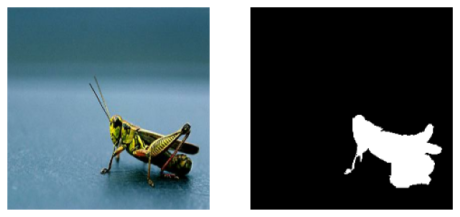

In [44]:
import os
import random
img_list = os.listdir('MSRA10K_Imgs_GT/Imgs/')

def load_and_preprocess(img_path, img_shape = [224,224],scale = True, expand_dims = False):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_image(img)

    # resizing image
    img = tf.image.resize(img,size = img_shape)

    # normalizing image
    if scale:
        img = img/255.0
    
    # expanding dimensions and type-casting to float32
    img = tf.cast(img,tf.float32)
    if expand_dims:
        img = tf.expand_dims(img,axis = 0)

    return img  

img_no = random.choice(img_list)[:-4]
test_img = load_and_preprocess(f'MSRA10K_Imgs_GT/Imgs/{img_no}.jpg',scale=True,img_shape = [224,224])
test_label = load_and_preprocess(f'MSRA10K_Imgs_GT/Imgs/{img_no}.png',scale=False,img_shape = [224,224])

fig,axs = plt.subplots(1,2,figsize = (8,6))

axs[0].imshow(tf.squeeze(test_img))
axs[0].axis('off')
axs[1].imshow(tf.squeeze(test_label),cmap='gray')
axs[1].axis('off')
plt.show()


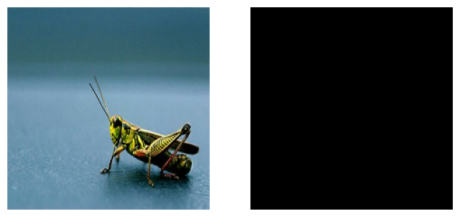

In [46]:
pred_img = quicksal.predict(tf.expand_dims(test_img,axis = 0),verbose = 0)
fig,axs = plt.subplots(1,2,figsize = (8,6))

axs[0].imshow(tf.squeeze(test_img))
axs[0].axis('off')
axs[1].imshow(tf.squeeze(pred_img),cmap='gray')
axs[1].axis('off')
plt.show()